# TV1 Algorithm

In [1]:
import numpy as np
from scipy.ndimage import gaussian_filter, convolve
from scipy.linalg import toeplitz
from scipy.signal import fftconvolve
from scipy.optimize import minimize


In [2]:
def degrade_image(image, psf_size=5, noise_var=0.01):
    psf = np.ones((psf_size, psf_size)) / (psf_size ** 2)
    blurred = convolve(image, psf, mode='reflect')
    noise = np.random.normal(0, np.sqrt(noise_var), image.shape)
    return blurred + noise, psf


In [3]:
def create_convolution_matrix(psf, shape):
    # Assumes circular boundary conditions
    from scipy.signal import fftconvolve
    kernel = np.pad(psf, [(0, shape[0] - psf.shape[0]), (0, shape[1] - psf.shape[1])], mode='constant')
    kernel = np.roll(kernel, -np.array(psf.shape) // 2, axis=(0, 1))
    return lambda x: fftconvolve(x, kernel, mode='same')

def apply_psf(image, psf):
    return fftconvolve(image, psf, mode='same')

from scipy.fft import fft2, ifft2


def precompute_psf_fft(psf, image_shape):
    psf_padded = np.pad(psf, [(0, image_shape[0] - psf.shape[0]),
                              (0, image_shape[1] - psf.shape[1])], mode='constant')
    psf_padded = np.roll(psf_padded, -np.array(psf.shape) // 2, axis=(0, 1))
    return fft2(psf_padded)

def apply_psf_fft_cached(image, psf_fft):
    image_fft = fft2(image)
    result_fft = image_fft * psf_fft
    return np.real(ifft2(result_fft))


In [4]:
def compute_weight_matrix(x):
    grad_x = np.gradient(x, axis=0)
    grad_y = np.gradient(x, axis=1)
    grad_mag = np.sqrt(grad_x**2 + grad_y**2)
    return 1 / (grad_mag + 1e-3)  # Avoid division by zero


In [5]:
from scipy.sparse import diags

def sparse_laplacian(shape):
    n = shape[0] * shape[1]  # Total number of pixels
    diagonals = [-4 * np.ones(n), np.ones(n-1), np.ones(n-1), np.ones(n-shape[1]), np.ones(n-shape[1])]
    offsets = [0, -1, 1, -shape[1], shape[1]]
    L = diags(diagonals, offsets, shape=(n, n), format='csr')
    return L


In [6]:
def solve_regularized(A, y, reg_param, laplacian):
    ATA = A.T @ A + reg_param * laplacian
    ATy = A.T @ y
    x = np.linalg.solve(ATA, ATy)
    return x

from scipy.sparse.linalg import cg

def solve_regularized_sparse(A_func, y, reg_param, laplacian):
    from scipy.sparse.linalg import LinearOperator

    def matvec(x_vec):
        x_image = x_vec.reshape(y.shape)  # Reshape vector to 2D
        Ax = A_func(x_image)             # Apply convolution in 2D
        Ax_flat = Ax.ravel()             # Flatten Ax to 1D
        return Ax_flat + reg_param * (laplacian @ x_vec)


    shape = y.size
    lin_op = LinearOperator((shape, shape), matvec=matvec)

    # Solve using Conjugate Gradient
    x, _ = cg(lin_op, y.ravel())
    return x.reshape(y.shape)



## TV1

In [7]:
def tv1_algorithm(y, psf, max_iter=50, reg_param=1e-2):
    from scipy.sparse.linalg import LinearOperator, cg

    # Precompute PSF FFT
    psf_fft = precompute_psf_fft(psf, y.shape)

    def A_func(img):
        return apply_psf_fft_cached(img, psf_fft)

    laplacian = sparse_laplacian(y.shape)
    x = y.copy()

    for i in range(max_iter):
        print(f"Iteration {i + 1}/{max_iter}...")

        def matvec(x_vec):
            x_image = x_vec.reshape(y.shape)
            Ax = A_func(x_image)
            return (Ax.ravel() + reg_param * (laplacian @ x_vec))

        lin_op = LinearOperator((y.size, y.size), matvec=matvec)
        x_new, _ = cg(lin_op, y.ravel(), maxiter=200, tol=1e-4)

        if np.linalg.norm(x - x_new.reshape(y.shape)) < 1e-3:
            print(f"Converged at iteration {i + 1}")
            break

        x = x_new.reshape(y.shape)

    return x, psf


Application

In [8]:
#pip install opencv-python


C:\Users\86173\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


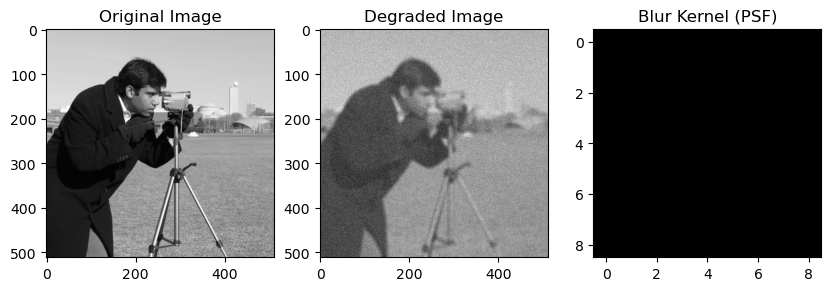

In [9]:
from skimage.data import camera
import matplotlib.pyplot as plt

# Load a test image (Cameraman from skimage)
original_image = camera().astype(np.float32) / 255.0

# Generate degraded image
degraded_image, psf = degrade_image(original_image, psf_size=9, noise_var=0.01)

# Display the images
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1), plt.title("Original Image"), plt.imshow(original_image, cmap='gray')
plt.subplot(1, 3, 2), plt.title("Degraded Image"), plt.imshow(degraded_image, cmap='gray')
plt.subplot(1, 3, 3), plt.title("Blur Kernel (PSF)"), plt.imshow(psf, cmap='gray')
plt.show()


Iteration 1/50...
Iteration 2/50...
Converged at iteration 2


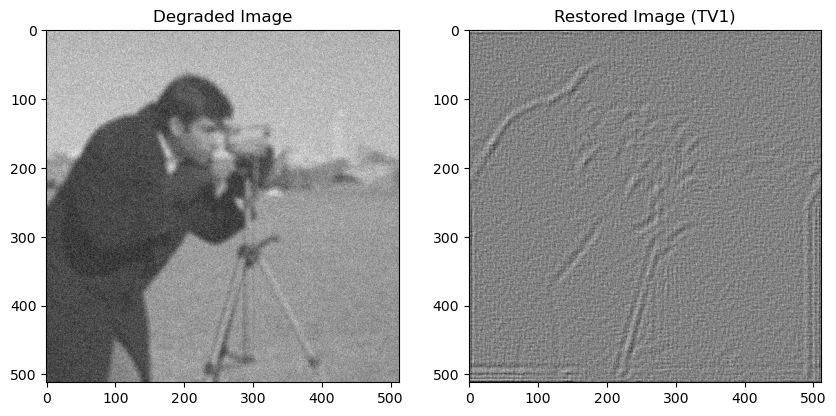

In [10]:
restored_tv1, estimated_psf_tv1 = tv1_algorithm(degraded_image, psf, max_iter=50)

# Display the results
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1), plt.title("Degraded Image"), plt.imshow(degraded_image, cmap='gray')
plt.subplot(1, 2, 2), plt.title("Restored Image (TV1)"), plt.imshow(restored_tv1, cmap='gray')
plt.show()


ISNR calculation

In [12]:
def calculate_isnr(original, degraded, restored):
    
    num = np.sum((original - degraded) ** 2)  # Noise before restoration
    den = np.sum((original - restored) ** 2)  # Noise after restoration
    return 10 * np.log10(num / den)




# Calculate ISNR for TV1
isnr_tv1 = calculate_isnr(original_image, degraded_image, restored_tv1)
print(f"ISNR (TV1): {isnr_tv1:.2f} dB")


ISNR (TV1): -89.55 dB
